<a href="https://colab.research.google.com/github/mitali-g/MachineLearning/blob/master/Squeeze_Net_Chest_Xray_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Input, GlobalAveragePooling2D, BatchNormalization, concatenate
from keras.layers import Dropout, Concatenate, Activation
from keras.layers import Convolution3D, MaxPooling3D, AveragePooling3D
from keras.layers import GlobalMaxPooling3D, GlobalAveragePooling3D
from keras.utils import np_utils
import os, cv2, random
import pandas as pd
%matplotlib inline

In [46]:
!unzip -q NEW_Resized_Dataset.zip

replace Resized_Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
!ls Resized_Dataset/train-equalized|wc

   5291    5291  137110


In [62]:
dataset = pd.read_csv("Resized_Dataset/Chest_xray_Corona_Metadata.csv")
print(dataset.shape)
dataset[5282:]

(5906, 6)


,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5282,5309,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN
5283,5310,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN
5284,5311,IM-0017-0001.jpeg,Normal,TEST,NaN,NaN
5285,5312,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN
5286,5313,IM-0015-0001.jpeg,Normal,TEST,NaN,NaN
...,...,...,...,...,...,...
5901,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5902,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5903,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5904,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [63]:
dataset = dataset[['X_ray_image_name', 'Label']]

In [64]:
x_train_features = dataset[['X_ray_image_name']]
x_train_features = x_train_features[0:5282]
#print(x_train_features)

In [65]:
y_train_labels = dataset[['Label']]
y_train_labels = y_train_labels[0:5282]
#print(y_train_labels)

In [66]:
from sklearn.utils import shuffle
train_dataset = dataset[0:5282]
test_dataset = dataset[5282:]

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

In [67]:
x_train_features = train_dataset['X_ray_image_name']
y_train_labels = train_dataset['Label']

In [68]:
y_train = []
for label in y_train_labels:
  if label == 'Pnemonia':
    y_train.append(1)
  elif label == 'Normal':
    y_train.append(0)
  else:
    print(label)
#print(y_train)
y_train = keras.utils.to_categorical(y_train)
print(y_train)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [69]:
x_test_features = dataset[['X_ray_image_name']]
x_test_features = x_test_features[5282:]
#print(x_test_features)

In [70]:
y_test_labels = dataset[['Label']]
y_test_labels = y_test_labels[5282:]
#print(y_test_labels)

x_test_features = test_dataset['X_ray_image_name']
y_test_labels = test_dataset['Label']

In [71]:
import os
list_of_images = os.listdir('Resized_Dataset/train-equalized')
len(list_of_images)

5291

In [72]:
y_test = []
for label in y_test_labels:
  if label == 'Pnemonia':
    y_test.append(1)
  elif label == 'Normal':
    y_test.append(0)
  else:
    print(label)
#print(y_test)
y_test = keras.utils.to_categorical(y_test)
print(y_test)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


5282

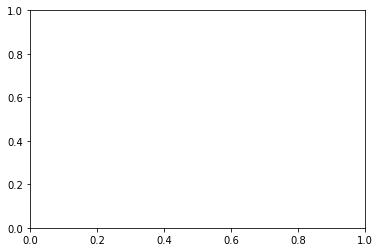

In [73]:
x_train = []
train_path = ('Resized_Dataset/train-equalized/')

for image in x_train_features:
  if ('.jpg' in image) == True:
        image = image[:image.rfind('.jpg')]
  elif ('.jpeg' in image) == True:
        image = image[:image.rfind('.jpeg')]
  elif ('.png' in image) == True:
        image = image[:image.rfind('.png')]
  image_path = train_path + image
  if os.path.isfile(image_path + '.png'):
    image = plt.imread(image_path + '.png')
    plt.grid(False)
    x_train.append(image)
len(x_train)

624

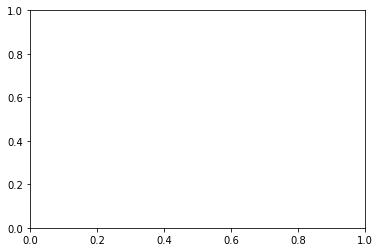

In [74]:
x_test = []

test_path = ('Resized_Dataset/test-equalized/')

for image in x_test_features:
  # image.rfind : removes '.jpeg'
  image_path =test_path + image[:image.rfind('.jpeg')]

  if os.path.isfile(image_path + '.png'):
    image = plt.imread(image_path + '.png')
    plt.grid(False)
    # plt.imshow(image)
    # plt.show()
    x_test.append(image)
len(x_test)

In [75]:
x_train = np.array(x_train, np.float16) / 255.0
y_train = np.array(y_train)
print(len(x_train), len(y_train), x_train.shape, y_train.shape)

x_test = np.array(x_test, np.float16) / 255.0
y_test = np.array(y_test)
print(len(x_test), len(y_test), x_test.shape, y_test.shape)

5282 5282 (5282, 256, 256) (5282, 2)
624 624 (624, 256, 256) (624, 2)


In [90]:
# https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb
# https://codelabs.developers.google.com/codelabs/keras-flowers-squeezenet/#6 
bnmomentum=0.9
def fire(x, squeeze, expand):
  y = Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
  y = BatchNormalization(momentum=bnmomentum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
  y1 = BatchNormalization(momentum=bnmomentum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  y3 = BatchNormalization(momentum=bnmomentum)(y3)
  return concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)
x = Input(shape=[256, 256, 1])
y = fire_module(squeeze=20, expand=80)(x) # squeeze is less than expand
y = fire_module(squeeze=20, expand=80)(y)


y = Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = BatchNormalization(momentum=bnmomentum)(y)
y = fire_module(30, 60)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(30, 150)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(30, 250)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(30, 150)(y)
y = MaxPooling2D(pool_size=2)(y)
y = fire_module(30, 60)(y)
y = GlobalAveragePooling2D()(y)
y = Dense(2, activation='softmax')(y)
model = tf.keras.Model(x, y)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 256, 256, 32) 320         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_127 (BatchN (None, 256, 256, 32) 128         conv2d_127[0][0]                 
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 256, 256, 30) 990         batch_normalization_127[0][0]    
____________________________________________________________________________________________

In [91]:
validation_split = 0.25
history = model.fit(x_train, y_train, epochs = 5, validation_split=validation_split)

Epoch 1/5
124/124 [==============================] - 71s 575ms/step - loss: 0.2714 - accuracy: 0.8970 - val_loss: 1.5947 - val_accuracy: 0.7525
Epoch 2/5
124/124 [==============================] - 69s 557ms/step - loss: 0.1408 - accuracy: 0.9482 - val_loss: 0.7577 - val_accuracy: 0.7752
Epoch 3/5
124/124 [==============================] - 69s 559ms/step - loss: 0.1210 - accuracy: 0.9518 - val_loss: 0.3913 - val_accuracy: 0.8410
Epoch 4/5
124/124 [==============================] - 69s 560ms/step - loss: 0.0920 - accuracy: 0.9689 - val_loss: 0.1021 - val_accuracy: 0.9629
Epoch 5/5
124/124 [==============================] - 69s 556ms/step - loss: 0.0754 - accuracy: 0.9740 - val_loss: 0.5402 - val_accuracy: 0.8471


20/20 [==============================] - 3s 167ms/step - loss: 0.3684 - accuracy: 0.8654
0.3683775067329407 0.8653846383094788


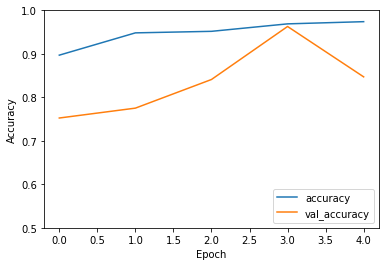

In [92]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test)
print(test_loss, test_acc)